In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
transform = transforms.ToTensor()

# Loading and visualizing the data

In [105]:
train_data = datasets.MNIST(root = r"C:\Users\mahdis\Desktop\Image" , train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = r"C:\Users\mahdis\Desktop\Image", train = False, download = True, transform = transform)

In [106]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\mahdis\Desktop\Image
    Split: Train
    StandardTransform
Transform: ToTensor()

In [107]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\mahdis\Desktop\Image
    Split: Test
    StandardTransform
Transform: ToTensor()

In [108]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [109]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


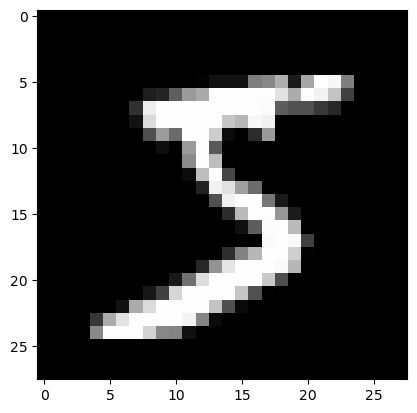

In [110]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

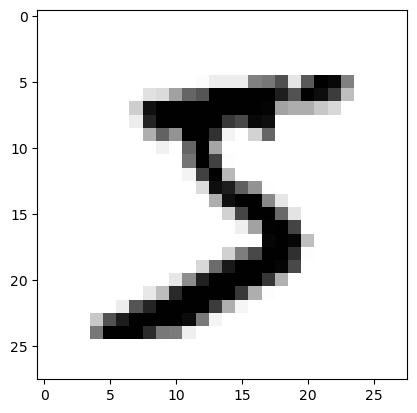

In [111]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

In [112]:
torch.manual_seed(42)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

# Structuring the model

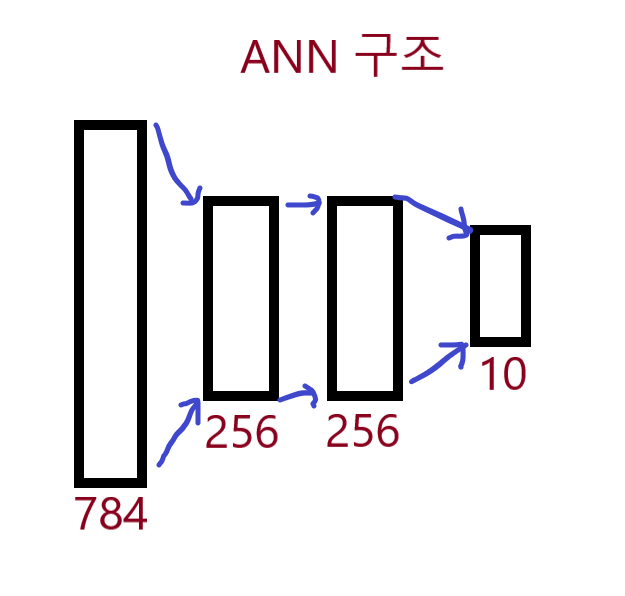

In [113]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0]) # 784 - 120
        self.fc2 = nn.Linear(layers[0],layers[1]) # 120 - 84
        self.fc3 = nn.Linear(layers[1],out_sz) # 84 -10
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

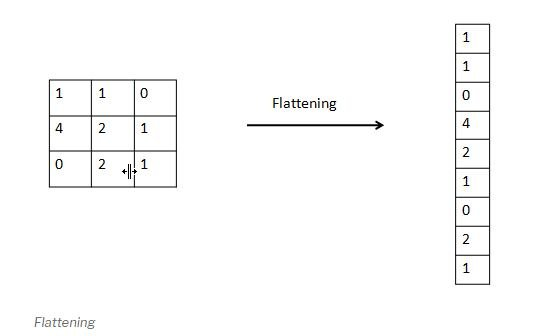

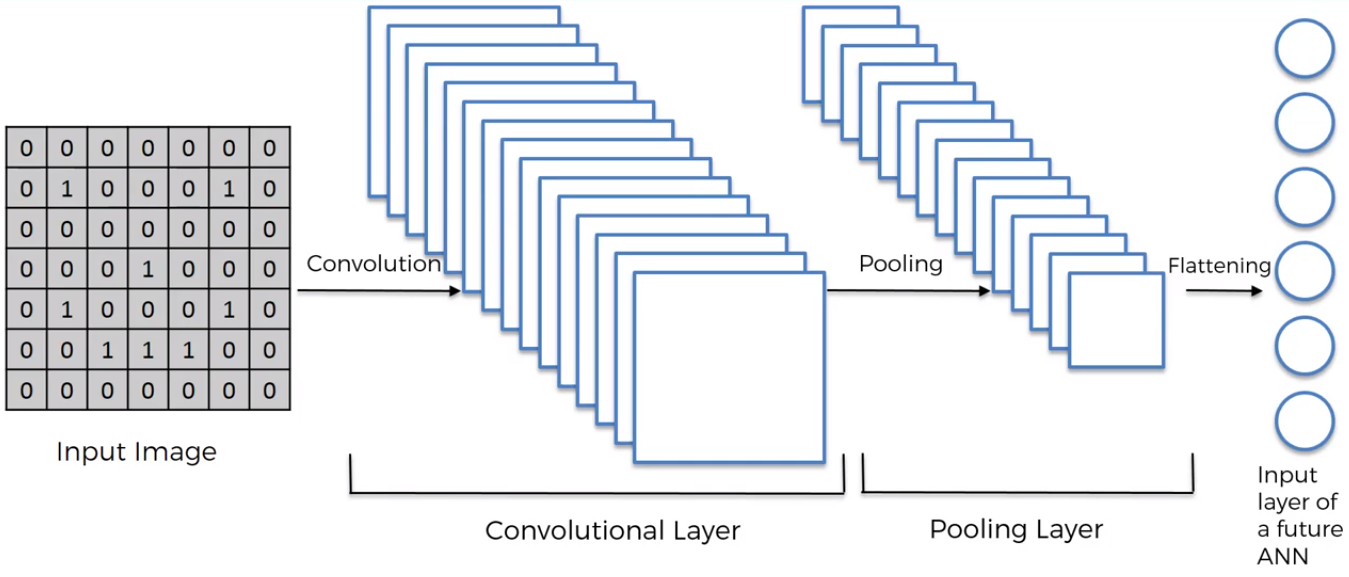

In [114]:
torch.manual_seed(42)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [115]:
par = 0
for param in model.parameters():
    par += param.numel()
    
par

105214

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [117]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [118]:
# FLATTENING THEM:
images.view(100,-1).size()

torch.Size([100, 784])

# Training

In [119]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.16993889  accuracy:  82.165%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.23571321  accuracy:  86.838%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.16012296  accuracy:  89.133%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.18333574  accuracy:  94.850%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.13760023  accuracy:  95.172%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.16903028  accuracy:  95.385%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.10027166  accuracy:  96.730%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.13561685  accuracy:  96.787%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.09773353  accuracy:  96.862%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.04479321  accuracy:  97.870%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.04398247  accuracy:  97.695%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.02360093  accuracy:  97.640%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.07021816  accuracy:  98.025%
epoch:  4  b

# Plot the loss and accuracy comparisons

training for too many epochs can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.

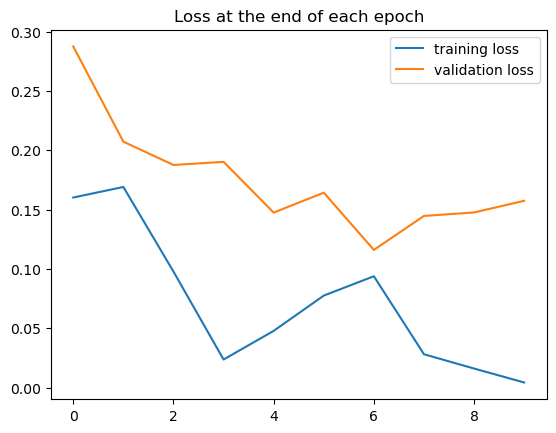

In [120]:
plt.plot(torch.stack(train_losses).cpu().detach().numpy(), label= 'training loss')
plt.plot(torch.stack(test_losses).cpu().detach().numpy(), label= 'validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

So we don't see any overfitting as the model is working fine on both train and test datasets

## Evaluating Test Data

In [121]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9457), tensor(9631), tensor(9688), tensor(9692), tensor(9754), tensor(9721), tensor(9767), tensor(9751), tensor(9773), tensor(9770)]

Test accuracy: 97.700%


# All the data 

In [122]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [123]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9770/10000 =  97.700%


# Display the confusion matrix

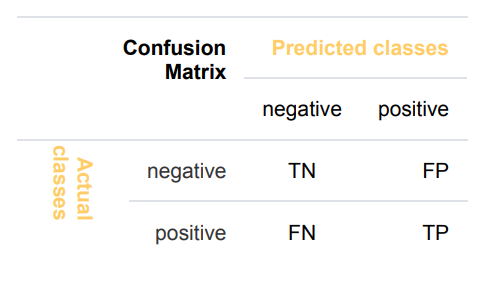

In [124]:
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))
#  0     1     2    3    4    5    6    7    8    9

[[ 971    0   10    0    1    2    3    0    4    1]
 [   0 1122    3    0    0    0    1    2    0    2]
 [   0    2  982    1    1    0    1    5    1    0]
 [   1    2    5  980    0    7    1    2    4    1]
 [   0    0    5    0  963    1    6    1    4    9]
 [   0    0    0    9    1  874    7    0    4    5]
 [   2    2    3    0    4    3  935    0    3    0]
 [   2    1   15    7    3    1    0 1012    3    5]
 [   3    6    9    9    0    2    4    2  946    1]
 [   1    0    0    4    9    2    0    4    5  985]]


# Examine the misses

In [125]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

230

In [126]:
(10000 - 497) / 10000

0.9503

In [127]:
# Display the first 10 index positions
misses[:16]

array([  18,  217,  247,  321,  381,  400,  445,  495,  582,  613,  619,
        659,  684,  691,  740,  877], dtype=int64)

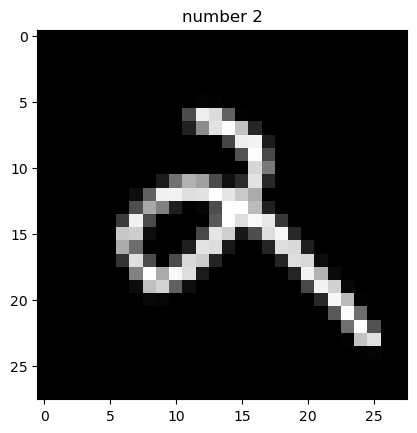

In [128]:
plt.imshow(test_data[149][0].view(28, 28), cmap = 'gray')
plt.title(f'number {test_data[149][1] }')
plt.show()

In [129]:
# Create a 4x4 subplot grid

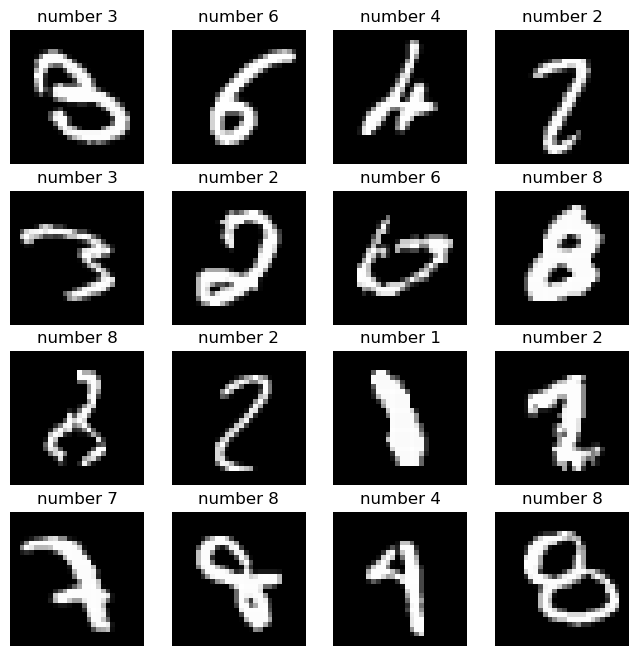

In [130]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):
    for j in range(4):
        # Index of the test example to display
        
        idxx = misses[:16]
        idx = i * 4 + j
        
        axs[i, j].imshow(test_data[idxx[idx]][0].view(28, 28), cmap='gray')
        axs[i, j].set_title(f'number {test_data[idxx[idx]][1]}')
        axs[i, j].axis('off')
        
plt.show()